# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. 

In [199]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

from sklearn.cluster import KMeans
import scipy.spatial.distance as distance
import numpy as np
from sklearn.metrics import silhouette_samples, silhouette_score
#import sklearn.decomposition
from sklearn.decomposition import PCA

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [200]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheetname=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()
#print(df_offers.shape)

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [201]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheetname=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()
#print(df_transactions.shape)

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

In [202]:
df_merge = pd.merge(df_transactions,df_offers)
#df_merge = df_transactions.merge(df_offers) #default inner join
#df_merge = df_transactions.merge(df_offers, how ='left' ) # gives identical result as inner
#df_merge = df_transactions.merge(df_offers, left_on ='offer_id', right_on = 'offer_id') # gives identical result
df_merge.head()

,customer_name,offer_id,n,campaign,varietal,min_qty,discount,origin,past_peak
0,Smith,2,1,January,Pinot Noir,72,17,France,False
1,Rodriguez,2,1,January,Pinot Noir,72,17,France,False
2,Martin,2,1,January,Pinot Noir,72,17,France,False
3,Jackson,2,1,January,Pinot Noir,72,17,France,False
4,Campbell,2,1,January,Pinot Noir,72,17,France,False


In [203]:
df_merge.shape

(324, 9)

In [67]:
customers = []
for i in df_merge['customer_name']:
    if i not in customers:
        customers.append(i)
print(len(customers)) #unique customers

100


In [204]:
matrix = df_merge.pivot_table(index=['customer_name'], columns=['offer_id'], values='n')
matrix = matrix.fillna(0).reset_index() #why reset index? Because we need x_cols
#matrix = matrix.fillna(0)
matrix.head()

offer_id,customer_name,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## K-Means Clustering

In K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. Let's investigate two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 



In [205]:
x_cols = matrix[matrix.columns[1:]]
x_cols.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [206]:
k_range = range(2,11)
k_means_fits = [KMeans(n_clusters=k).fit(x_cols) for k in k_range]
centroids = [X.cluster_centers_ for X in k_means_fits]
print(centroids[0].shape,x_cols.shape)

(2, 32) (100, 32)


In [59]:
len(centroids) # nine different cases, k=2,3, ..., 10

1

In [207]:
k_euclid = [distance.cdist(x_cols, cent) for cent in centroids]
#k_euclid[0].shape
dist = [np.min(ke,axis =1) for ke in k_euclid]
#dist[0].shape
wcss = [sum(d**2) for d in dist] #within-cluster sum of squares
tss = sum(distance.pdist(x_cols)**2)/matrix.shape[0] #total sum of squares
bss = tss - wcss #between cluster sum of square
print('Total ',tss,', within ',wcss,' between ',bss)

Total  281.9 , within  [251.46031746031741, 227.73611111111103, 213.56396396396394, 203.31071428571437, 194.96896875810222, 187.5262529137529, 180.89938657833392, 173.82943722943719, 168.42222222222227]  between  [  30.43968254   54.16388889   68.33603604   78.58928571   86.93103124
   94.37374709  101.00061342  108.07056277  113.47777778]


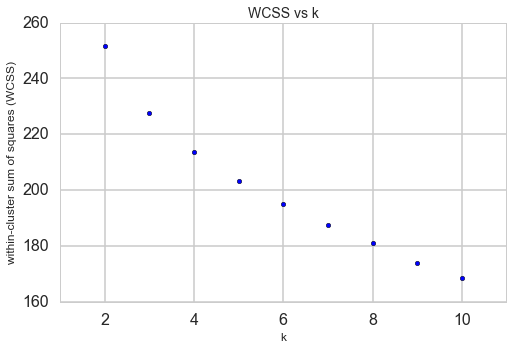

In [208]:
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(k_range, wcss)

ax.set_xlabel('k', fontsize=12)
ax.set_ylabel('within-cluster sum of squares (WCSS)', fontsize=12)
ax.set_title('WCSS vs k', fontsize=14)

In [209]:
#For n_clusters = 4
cluster = KMeans(n_clusters=4)
matrix['cluster'] = cluster.fit_predict(x_cols)
matrix.cluster.value_counts()

1    49
2    24
3    15
0    12
Name: cluster, dtype: int64

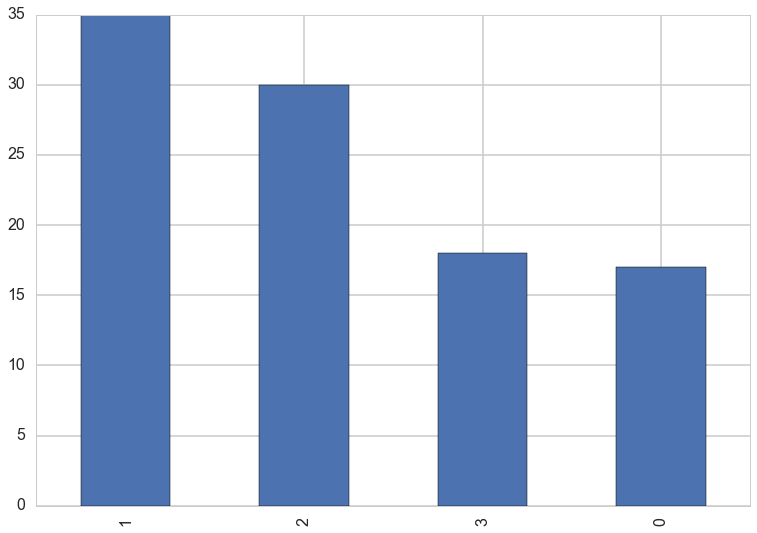

In [117]:
matrix.cluster.value_counts().plot(kind='bar')

In [210]:
#For n_clusters = 4
matrix.head()

offer_id,customer_name,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,cluster
0,Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2
1,Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
2,Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3
3,Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2
4,Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1


### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster and also how poorly it fits into other clusters. 

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap.

Scikit-learn provides a function to compute this called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). 

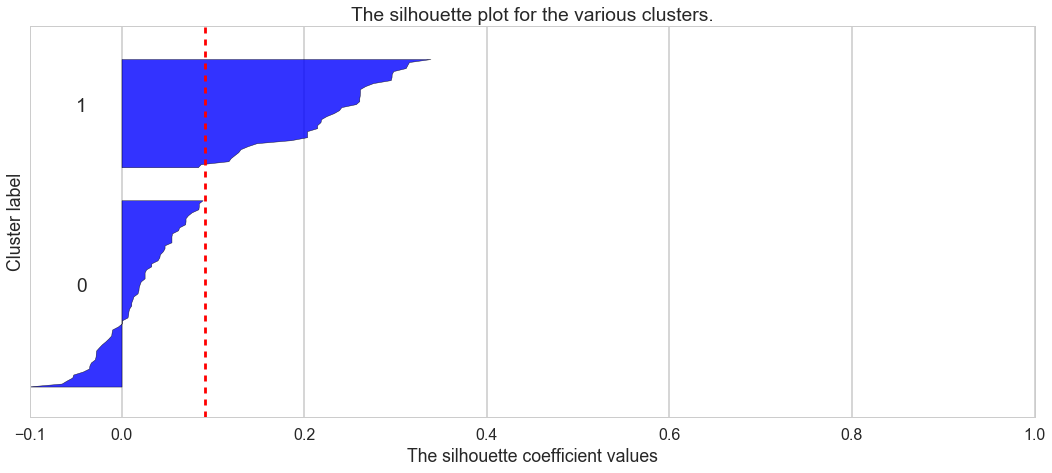

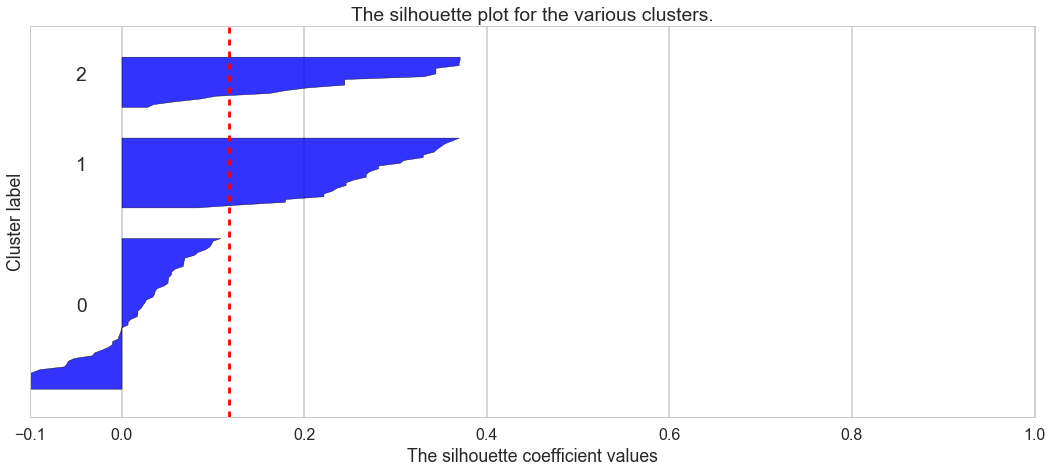

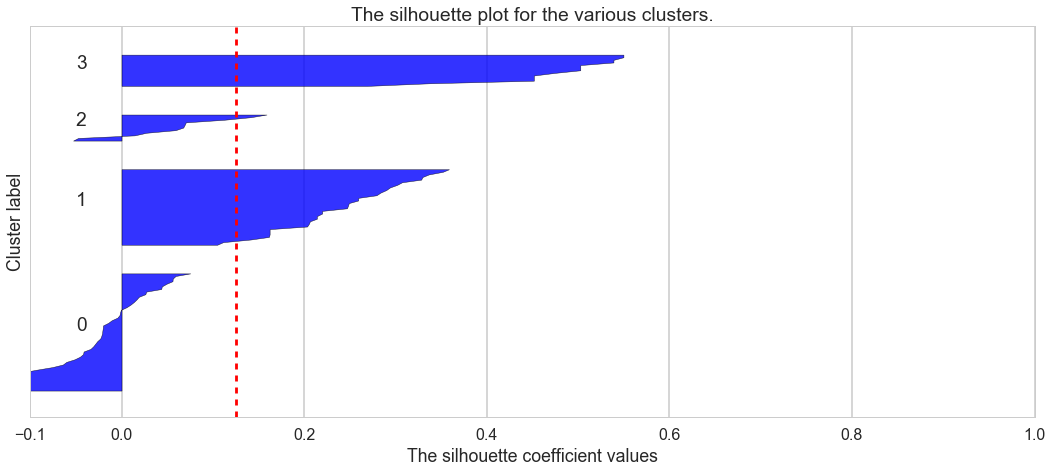

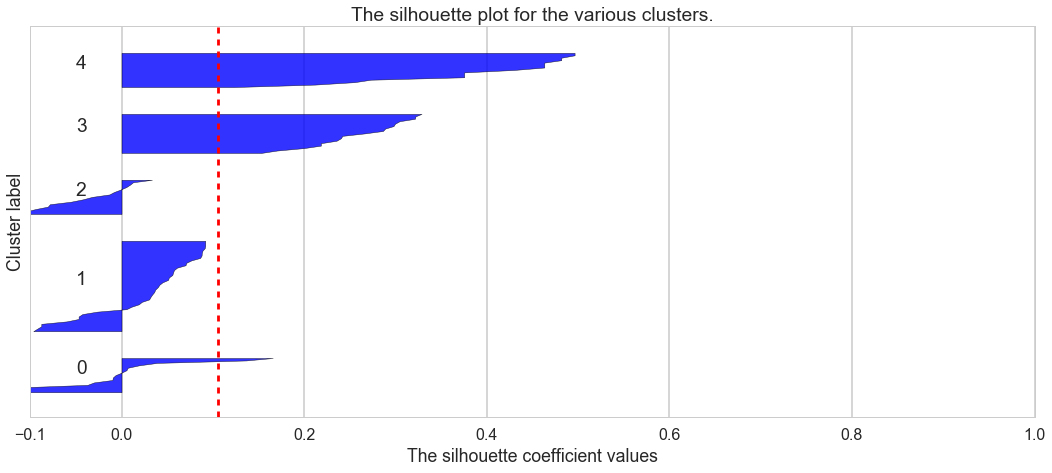

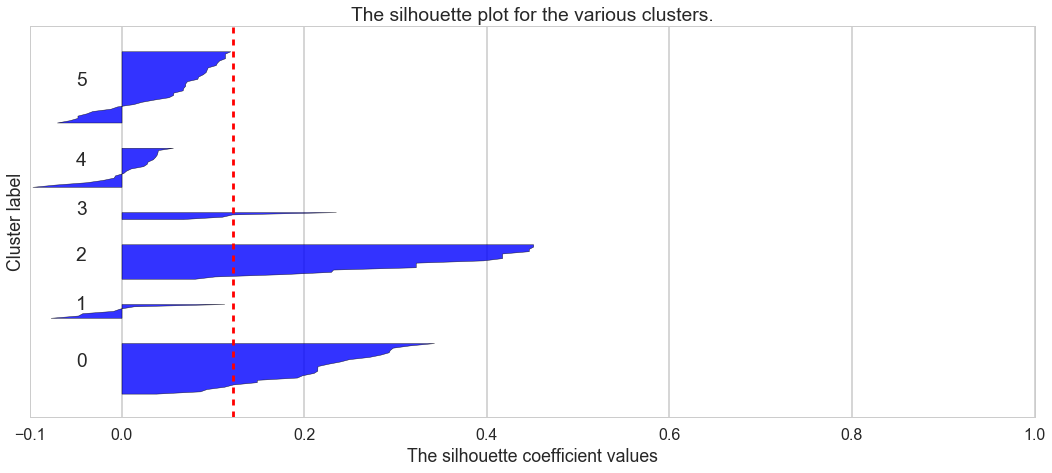

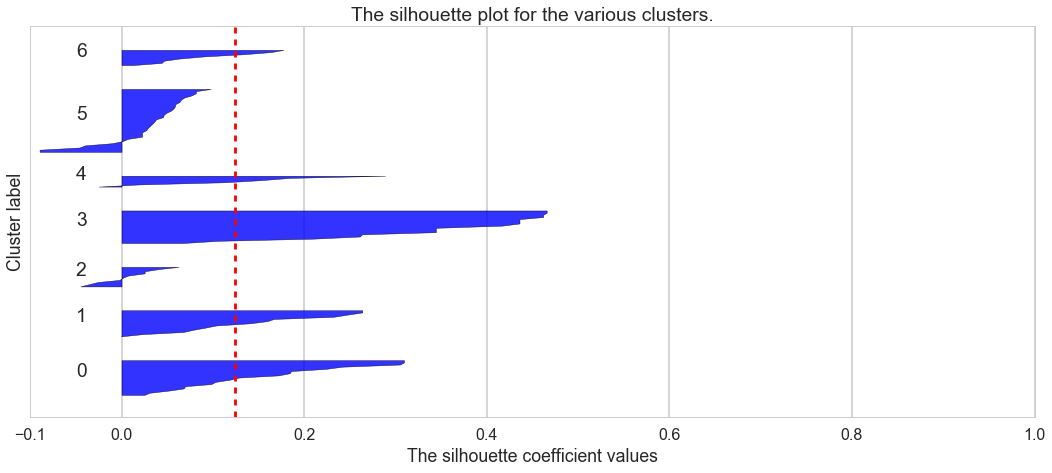

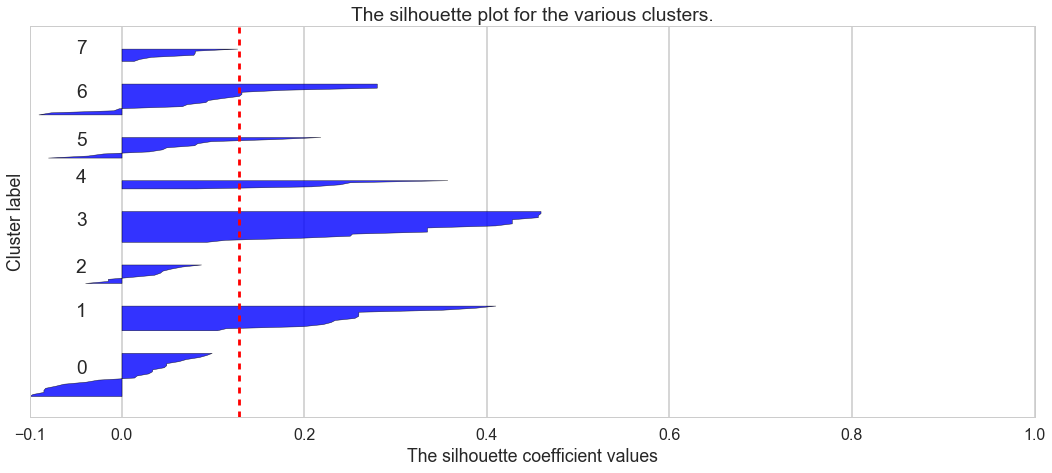

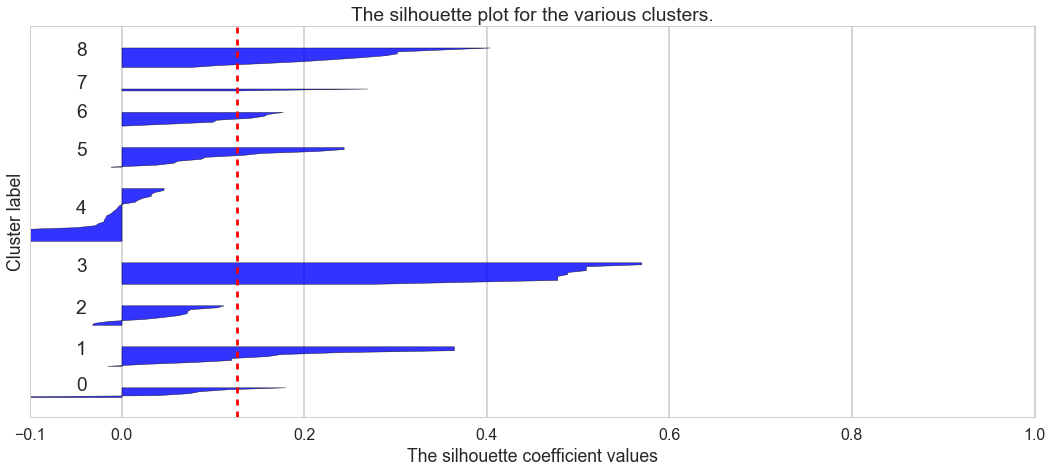

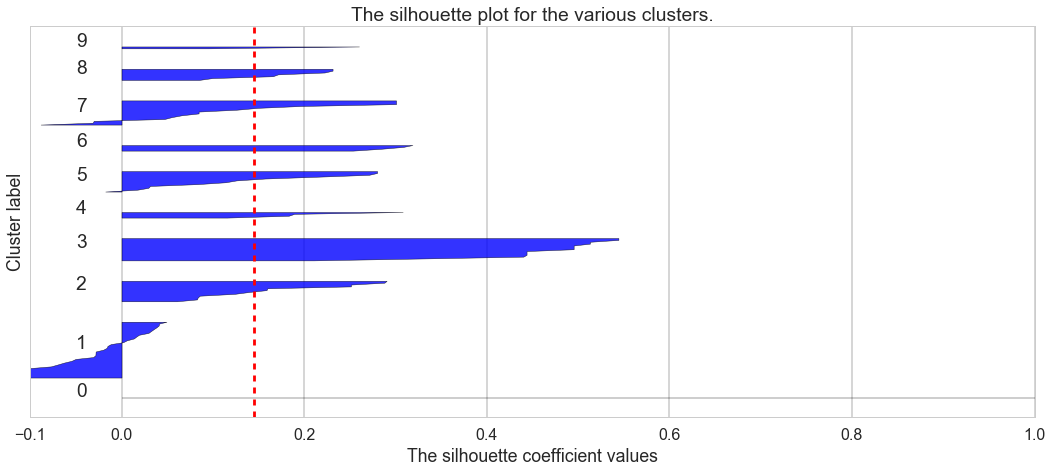

In [211]:
range_n_clusters = range(2,11)
silhouette_avgs = []  #list will hold avg Silhouette scores
for n_clusters in range_n_clusters:
    #n_clusters = 
    clusterer = KMeans(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(x_cols) #cluster label can be in the range (0, n_clusters-1)
    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    silhouette_avgs.append(silhouette_avg)
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)

    fig, ax1 = plt.subplots()
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(x_cols) + (n_clusters + 1) * 10])

    y_lower =10
    for i in range(n_clusters): #n_clusters
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i] #selection cluster 0,1,2,3
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0] # number of entries in cluster i
        y_upper = y_lower + size_cluster_i
        ax1.fill_betweenx(np.arange(y_lower,y_upper), 0, ith_cluster_silhouette_values, facecolor='blue', alpha=0.8)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


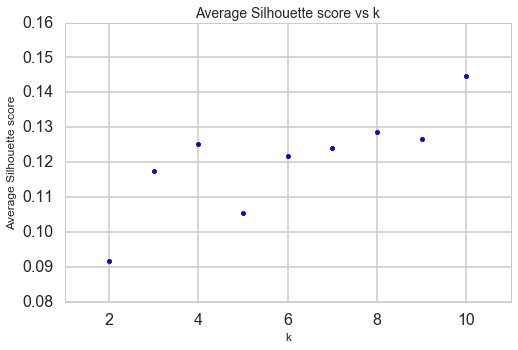

In [212]:
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(k_range, silhouette_avgs)

ax.set_xlabel('k', fontsize=12)
ax.set_ylabel('Average Silhouette score', fontsize=12)
ax.set_title('Average Silhouette score vs k', fontsize=14)

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.


In [227]:
#matrix = matrix.drop('cluster', 1) #reset/remove the clustering information
#matrix.head()

In [217]:
model = PCA(n_components = 2)
#model.fit(x_cols)
#print(model.components_)
#print(len(model.components_))
#print(model.explained_variance_)

#print(x_cols)  #100 samples with 32 dimensions

transf = model.fit_transform(x_cols)
#transf  #100 samples with 2 dimensions

In [218]:
type(transf)

numpy.ndarray

In [239]:
df_pca = pd.DataFrame(index=matrix['customer_name'],data=transf, columns=['x','y'])
cluster = KMeans(n_clusters=4)
df_pca['cluster']= cluster.fit_predict(x_cols)
df_pca.head(10)

,x,y,cluster
customer_name,,,
Adams,-1.007580,0.108215,2
Allen,0.287539,0.044715,1
Anderson,0.392032,1.038391,0
Bailey,-0.699477,-0.022542,2
Baker,-0.088183,-0.471695,3
Barnes,0.485282,-0.725503,3
Bell,0.591941,1.506500,0
Bennett,-0.661732,0.090308,2
Brooks,0.118943,-0.577499,1


In [274]:
#ggplot
from ggplot import *
#ggplot(df_pca, aes(x='x', y='y', color='cluster')) + geom_point(size=75) + ggtitle("Customers Grouped by Cluster")

In [250]:
colorMap = {0:'r', 1:'b', 2:'g', 3:'y'}  #red, blue, gree, yellow
df_pca2 = df_pca[:]

In [252]:
df_pca2['cluster_color'] = df_pca2['cluster'].map(colorMap)

/Users/aungshumaan/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [253]:
df_pca2.head()

,x,y,cluster,cluster_color
customer_name,,,,
Adams,-1.007580,0.108215,2,g
Allen,0.287539,0.044715,1,b
Anderson,0.392032,1.038391,0,r
Bailey,-0.699477,-0.022542,2,g
Baker,-0.088183,-0.471695,3,y


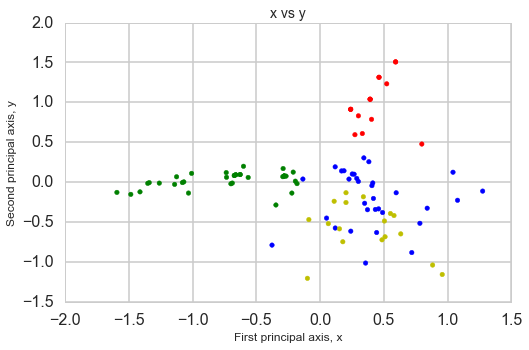

In [257]:
fig, ax = plt.subplots(figsize=(8,5))

ax.scatter(df_pca2['x'], df_pca2['y'], color = df_pca2['cluster_color'])
#ax.scatter(df_pca['x'], df_pca['y'])

ax.set_xlabel('First principal axis, x',  fontsize=12)
ax.set_ylabel('Second principal axis, y', fontsize=12)
ax.set_title('x vs y', fontsize=14)

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

In [270]:
# Initialize a new PCA model with a default number of components.

#k_means_fits = [KMeans(n_clusters=k).fit(x_cols) for k in k_range]

range_comp =[2,3,4,5,6,7,8,9,10]
explained_variances = []
sum_explained_variances = []
for comp in range_comp:
    pca = PCA(n_components = comp)
    pca.fit(x_cols)

    #print(pca.components_)
    #print(len(pca.components_))
    #print(pca.explained_variance_)
    explained_variances.append(pca.explained_variance_)
    sum_explained_variance = 0
    for i in range(len(pca.explained_variance_)):
        sum_explained_variance = sum_explained_variance + pca.explained_variance_[i]
    sum_explained_variances.append(sum_explained_variance)
#print(explained_variances)
print(sum_explained_variances)





[0.71001256554545189, 0.9102822381497927, 1.0756490341195635, 1.2242999929643719, 1.3663029206640755, 1.5031098990919756, 1.6238136141986201, 1.7390117122923845, 1.8459739942430027]


In [271]:
len(range_comp), len(sum_explained_variances)

(9, 9)

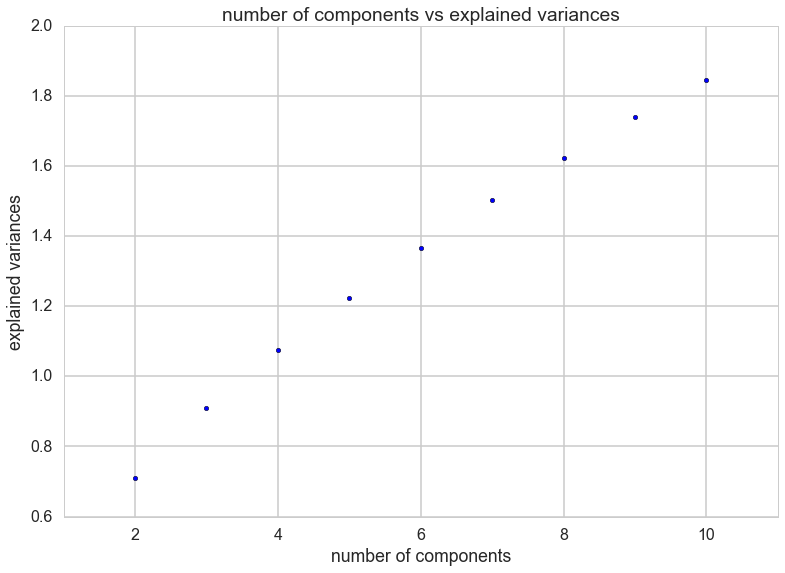

In [272]:
fig, ax = plt.subplots()

ax.scatter(range_comp, sum_explained_variances)
ax.set_xlabel('number of components')
ax.set_ylabel('explained variances')
ax.set_title('number of components vs explained variances')